In [50]:
#import  libraries,packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from data_reduction_columns import * 
from predict import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from predict import *

In [3]:
#import scikit-learn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Fannie Mae publishes quarterly data on loan acquisitions and performance in single file from the year of 2000. For the analysis purpose data from 2016 is considered. The entire dataset is very huge  Therefore, the important data is compiled into a single file with reduce_data.py before beginning this analysis. This routine serves to clean and trim the data, calculate a few values that will be useful later like the loan age, and identify loans that were foreclosed on. Acquistion and Performance files are so large they cannot be completely read into memory so "chunking" is used in the read_table function.  Additionally, data is sorted based on reporting period and most recent reporting period data for a given loan is considered as that gives the information wherther loan is foreclosured or not.


Lets start by analying the housing market during 2017 and 2016. What are the houses selling for, what's the range  and how levered are borrowers?

In [4]:
data = pd.read_table(DATA_DIR_OUTPUT+DATA_FILE,sep=",")

In [4]:
data.shape


(4336086, 37)

In [12]:
data['originalLoanAmt'].head(4)

0    238000.0
1     65000.0
2    153000.0
3    150000.0
Name: originalLoanAmt, dtype: float64

In [12]:
description = data[['originalLoanAmt','balance', 
                             'interest_rate', 
                             'dti', 
                             'loan_term',
                             'insurance_percentage'
                             ]].describe()
print(description[1:].round(2))


      originalLoanAmt     balance  interest_rate    dti  loan_term  \
mean        232440.75    51274.56           3.93  33.79     318.49   
std         119673.99    92009.71           0.54   9.10      74.83   
min           5000.00        0.00           1.75   0.00      36.00   
25%         140000.00        0.00           3.62  27.00     360.00   
50%         211000.00        0.00           3.99  35.00     360.00   
75%         307000.00    83364.28           4.25  41.00     360.00   
max        1223000.00  1227922.05           6.12  63.00     360.00   

      insurance_percentage  
mean                 24.83  
std                   7.00  
min                   1.00  
25%                  25.00  
50%                  25.00  
75%                  30.00  
max                  42.00  


In [5]:
data = data.drop(columns=["recovery_costs","foreclosure_date","borrower_credit_score_current","co-borrower_credit_score_current","insurance_type","insurance_percentage","co-borrower_credit_score","maturity_date"])
data.isnull().sum()

loanId                          0
reporting_period                0
channel                         0
seller                         70
interest_rate                   0
current_interest_rate     2921632
originalLoanAmt                 0
loan_term                       0
origination_date                0
balance                         0
loan_age                        0
ltv                             0
cltv                            0
borrowers_count                 0
dti                           353
borrower_credit_score        2409
first_time_homebuyer            0
loan_purpose                    0
property_type                   0
units_num                       0
property_state                  0
zip                             5
relocation_indicator            0
high_balance_loan_ind           0
acquisition_date                0
origination_date_month          0
origination_date_year           0
property_state_n                0
foreclosured                    0
dtype: int64

as per 2017 and 2016 data, loan balance range is huge.Also original loan amt varies from 200k to 1 million.  Interest Rate goes from 2% to 6 %. Most of the loans are 30 years loan

Lets look at the foreclosure data, we are counting number of foreclosed houses and calculate the rate at which they occur

In [8]:
(good,default) = pd.value_counts(data['foreclosured'])
print('Total Defaults =',default)
print('Total Good loans =',good)
print('Default Rate {:.1%}'.format(100 *default/(good+default))) 

grouped_data = data.groupby('origination_date_year')['foreclosured'].value_counts().unstack()
print(grouped_data)
for year,row in grouped_data.iterrows():
    print(f"{year} had {row[1]} defaults")

Total Defaults = 5209
Total Good loans = 4330877
Default Rate 12.0%
foreclosured                   0       1
origination_date_year                   
2013                         4.0     NaN
2014                       137.0     NaN
2015                    170561.0   272.0
2016                   2351021.0  2629.0
2017                   1809154.0  2308.0
2013 had nan defaults
2014 had nan defaults
2015 had 272.0 defaults
2016 had 2629.0 defaults
2017 had 2308.0 defaults


We have totaly 566  foreclosures wto work with, which is will helps us identify any characterstics of foreclosure. But they account for onlya  small percentage(11%).This means it is rare that a mortage defaults we need to keep account for this. We can use analytics to characterize groups that may have tendency to run into liquidity issues or buy at the wrong times. 


Lets analyse data to draw groups that have tendency for foreclosure. Debt to income ratios, primary  borrower's credit scores, loan to value ration are import features to consider, lets begin from here by drawing box and whisker plots for the same. These values helps agency to asses the credit worthiness of the borrower and relative riks of the loans.

In [6]:
for column in ["channel","seller","first_time_homebuyer","loan_purpose","property_type","property_state","high_balance_loan_ind",
        "relocation_indicator","loan_purpose"]:
        data[column] = data[column].astype('category').cat.codes

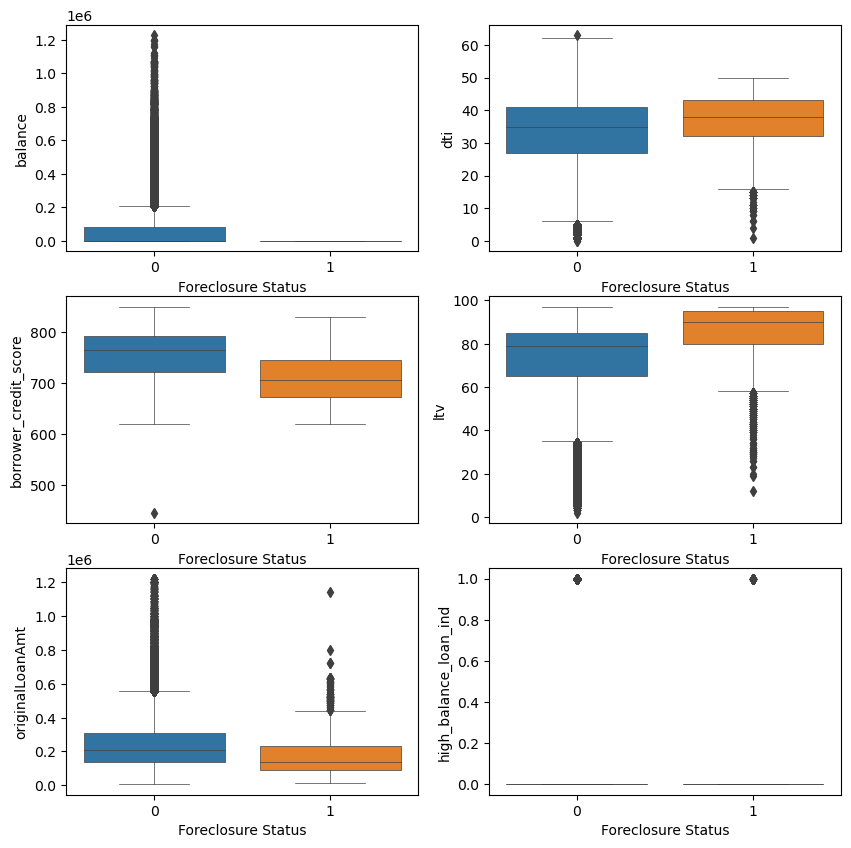

In [22]:
#columns to plot
columns = ['balance', 'dti','borrower_credit_score','ltv','originalLoanAmt','high_balance_loan_ind']

#make plot
fig, axes = plt.subplots(3, 2, figsize=(10,10))
for i, column in zip(range(1,7), columns):
    plt.subplot(3,2,i)
    sns.boxplot(x="foreclosured", y=column, data=data, linewidth=0.5)
    plt.xlabel('Foreclosure Status')



Box plots shows small variance among default and good loans

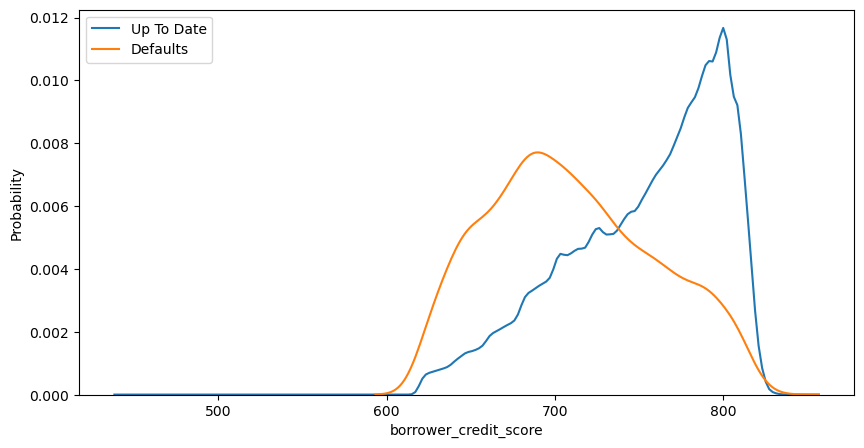

In [16]:
# Set-up plot and data
fig, ax = plt.subplots(1, 1, figsize=(10,5))
dist_data = data[['borrower_credit_score', 'foreclosured']].dropna(axis=0, how='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data[dist_data['foreclosured']==0]
sns.kdeplot(good_credit_scores['borrower_credit_score'], label = 'Up To Date')

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data[dist_data['foreclosured']==1]
sns.kdeplot(default_credit_scores['borrower_credit_score'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

probability density graph is showing that graph curve is different for defaults and good loans. Good loans are skewed towards right with high credit score where as default one was skewed towards left with peak of curve is around less than 700 credit score. But the interest rate among good and default is not varing much.

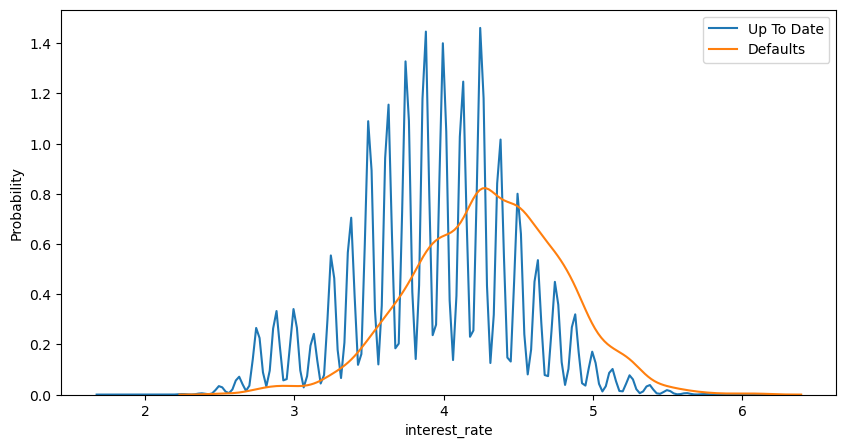

In [21]:
fig,ax = plt.subplots(1, 1, figsize=(10,5))
dist_data_1 = data[['interest_rate','foreclosured']].dropna(axis =0, how ='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data_1[dist_data_1['foreclosured']==0]
sns.kdeplot(good_credit_scores['interest_rate'], label = 'Up To Date')

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data_1[dist_data_1['foreclosured']==1]
sns.kdeplot(default_credit_scores['interest_rate'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

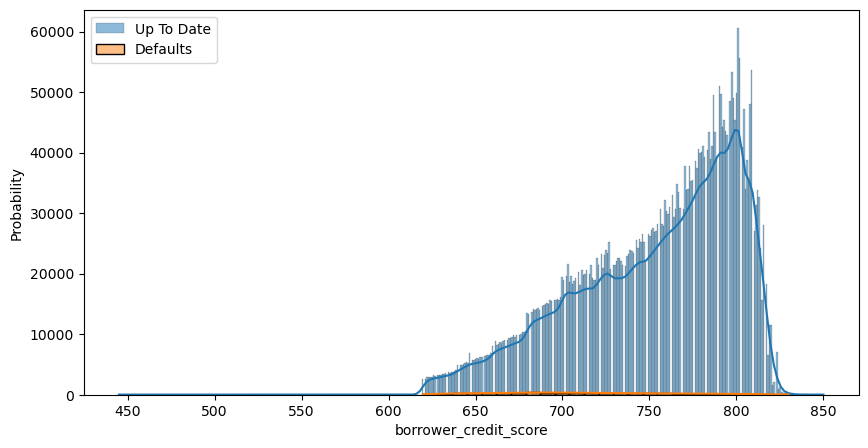

In [22]:
# Set-up plot and data
fig, ax = plt.subplots(1, 1, figsize=(10,5))
dist_data_2 = data[['borrower_credit_score', 'foreclosured']].dropna(axis=0, how='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data_2[dist_data_2['foreclosured']==0]
sns.histplot(good_credit_scores['borrower_credit_score'], label = 'Up To Date', kde= True)

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data_2[dist_data_2['foreclosured']==1]
sns.histplot(default_credit_scores['borrower_credit_score'], label='Defaults', kde= True)
ax.set_ylabel('Probability')
ax.legend();

negative value of pearson shows perfecy negative relationship that ie. borrower with good credit score gets lower interest rate. At the same time borrower with low credit score do gets loans but with higher interest rate.

In [23]:
print(data['interest_rate'].corr(data['borrower_credit_score'], method='pearson'))

-0.31773177295969035


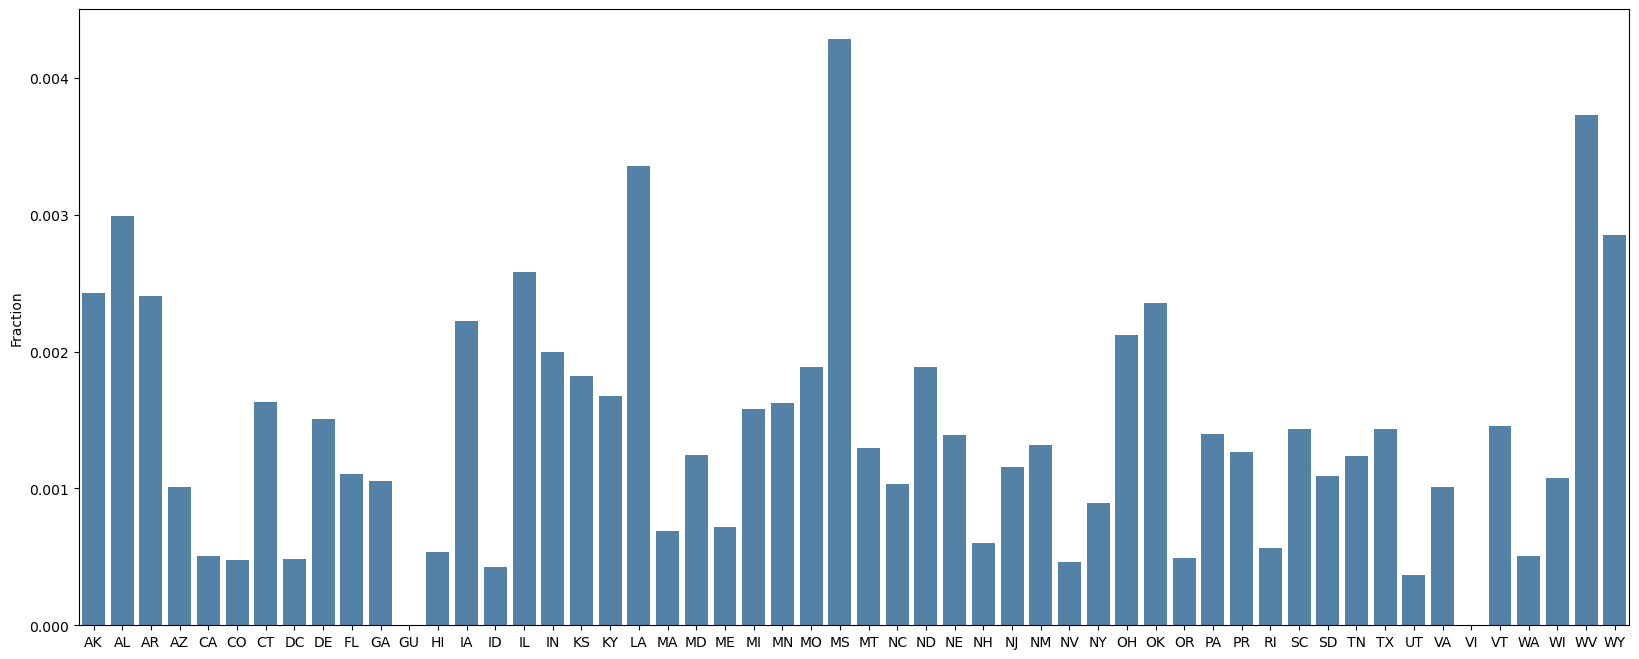

In [28]:
# Count number of mortgages per state
states_mort = pd.value_counts(data['property_state'])

# Count number of foreclosures and get ratio
states_defaults = data[data['foreclosured']==1]
states_foreclose_count = pd.value_counts(states_defaults['property_state']).sort_index()
states_mort = pd.concat([states_mort, states_foreclose_count], axis=1).fillna(0)
states_mort =states_mort.sort_index()
states_mort.columns = ['totals','defaults']

# Plot foreclosure rates
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.barplot(x=states_mort.index, y=states_mort['defaults']/states_mort['totals'], color='steelblue')
#sns.barplot(x=states_mort.index, y=states_mort['totals'], color='steelblue')
ax.set_ylabel('Fraction');



2016 abd 2017 data shows states having various foreclosure rates. Few states have very huge foreclosure rates where as few states have nil.since data combine two years of data 2016 and 217, we can also check whether each year foreclosure rate is different. 2016 and 2017 data files have loans which are originated from 2013 onwards. lets check the foreclosure of houses based on origination date.

In [29]:
grouped_data = data.groupby(['origination_date_year','foreclosured']).size().reset_index(name='count')
print(grouped_data)

   origination_date_year  foreclosured    count
0                   2013             0        4
1                   2014             0      137
2                   2015             0   170561
3                   2015             1      272
4                   2016             0  2351021
5                   2016             1     2629
6                   2017             0  1809154
7                   2017             1     2308


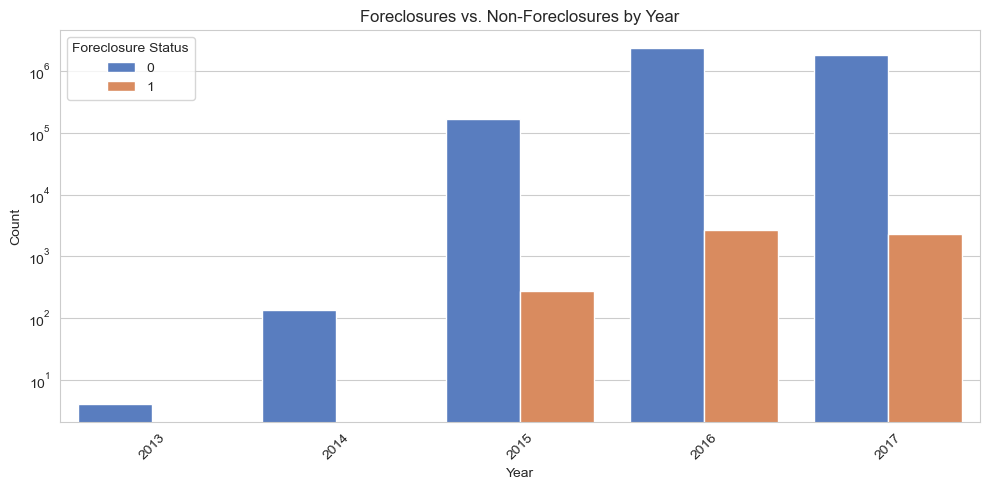

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(data=grouped_data, x ='origination_date_year', y = 'count', hue='foreclosured',palette='muted',dodge=0.2)
# Create a bar plot with overlapped bars
sns.set_style("whitegrid")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Foreclosures vs. Non-Foreclosures by Year')
plt.yscale('log')
# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Foreclosure Status', loc='upper left')
plt.tight_layout()
plt.show()


In [32]:
print('Interest Rate - Credit Score Correlation = ', data['interest_rate'].corr(data['borrower_credit_score'], method='pearson'))
print('Interest Rate - Debt Level = ', data['interest_rate'].corr(data['cltv'], method='pearson'))
print('Interest Rate - Loan Term = ', data['interest_rate'].corr(data['loan_term'], method='pearson'))

Interest Rate - Credit Score Correlation =  -0.31773177295969035
Interest Rate - Debt Level =  0.27782892918325325
Interest Rate - Loan Term =  0.591473485024441


To fit the logit function data will split into training and testing set. Data is highly imbalnced as foreclosured house count is way less compared to good houses. Due to this imbalance of data cross validation is used. Also to check the features that impact foreclosure feature selection function is used.Looks like credit score and loan balance do affect the foreclosured loans 

In [12]:
feature_selection(data)

Selected feature indices: [2 5]
Selected feature indices: ['originalLoanAmt', 'borrower_credit_score']


In [13]:
make_logistic_predictions(data)

filtered_data*****
LogicsticRegression: Cross-Validation Scores: [0.66916814 0.67186368 0.67424686]
Mean CV Score: 0.6717595608321941
LogicsticRegression: Standard Deviation of CV Scores: 0.0020746879869553243
LogicsticRegression : Test Set Accuracy: 0.6713904606679377
Confusion matrix
[[872162 426995]
 [   434   1129]]
************* LogicsticRegression Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.67      0.80   1299157
           1       0.00      0.72      0.01      1563

    accuracy                           0.67   1300720
   macro avg       0.50      0.70      0.40   1300720
weighted avg       1.00      0.67      0.80   1300720

***********************************************************************************
LogicsticRegression Accuracy score " 0.6713904606679377


1) Above results shows precison  for identifying the foreclousred loans is nil  where as number of forclosured loans correctly identified as positive out of all is 72%.
2) looking at confusion matrix only 1129 loans are identified correctly out of Total Defaults = 5209 
3) since number of default loans are very less compared to good one, we need to focus on F1 Score

In [ ]:
make_LogicsticRegression_scaled(data)

In [14]:
optimalC = Cvalue_section(data)

filtered_data*****


In [15]:
print(optimalC)

0.01


In [17]:
make_logistic_predictions(data,optimalC)

****filtered_data*****
LogicsticRegression: Cross-Validation Scores: [0.67197834 0.66707853 0.66851575]
Mean CV Score: 0.6691908733175113
LogicsticRegression: Standard Deviation of CV Scores: 0.002056515807605645
LogicsticRegression : Test Set Accuracy: 0.6690778953195153
Confusion matrix
[[869149 430008]
 [   429   1134]]
************* LogicsticRegression Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.67      0.80   1299157
           1       0.00      0.73      0.01      1563

    accuracy                           0.67   1300720
   macro avg       0.50      0.70      0.40   1300720
weighted avg       1.00      0.67      0.80   1300720

***********************************************************************************
LogicsticRegression Accuracy score " 0.6690778953195153


In [9]:
bestFeatures, bestParams = best_random_forest_parameters(data)

****filtered_data*****
Best parameters for random forest classification are  {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
**********************Features with importance *******************************
{'interest_rate': 0.15603621864996867, 'borrowers_count': 0.06639377272670108, 'dti': 0.1695690671582982, 'cltv': 0.1180085648320633, 'ltv': 0.10201215299698571, 'borrower_credit_score': 0.3265871276700195, 'high_balance_loan_ind': 0.003997665733535489, 'first_time_homebuyer': 0.021156010847864132, 'property_type': 0.03623941938456394}


gini


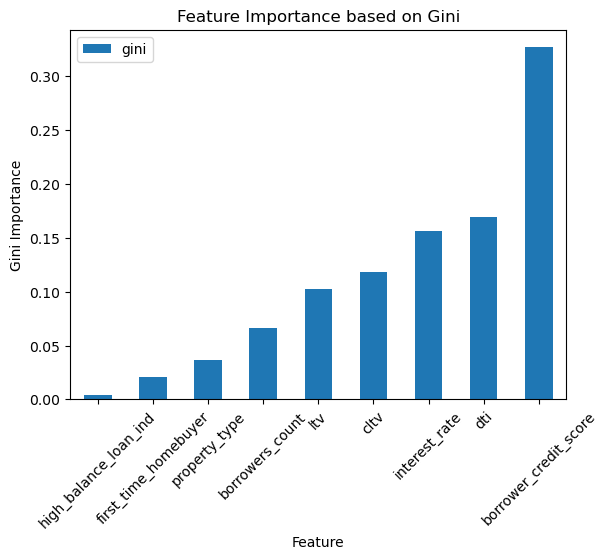

In [12]:
bestParameters = pd.DataFrame.from_dict([bestParams])
bestCriterion = bestParameters['criterion'] 
print(bestCriterion[0])
importances = pd.DataFrame.from_dict(bestFeatures, orient='index' ).rename(columns={0: bestCriterion[0]})
importances.sort_values(by = bestCriterion[0]).plot(kind='bar', rot=45)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Feature Importance based on Gini')
plt.show()

In [46]:
print(bestParameters['max_depth'][0])

None


In [51]:
make_random_forest_predictions(data,bestParameters,importances.index.tolist())

    

calling the function *****
****filtered_data*****
['interest_rate', 'borrowers_count', 'dti', 'cltv', 'ltv', 'borrower_credit_score', 'high_balance_loan_ind', 'first_time_homebuyer', 'property_type']
(1300002, 2)
Decision tree: Confusion matrix
[[1297723     719]
 [   1557       3]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1298442
           1       0.00      0.00      0.00      1560

    accuracy                           1.00   1300002
   macro avg       0.50      0.50      0.50   1300002
weighted avg       1.00      1.00      1.00   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.9982492334627178


In [53]:
columns = ['dti', 'borrower_credit_score','originalLoanAmt']
make_random_forest_predictions(data,bestParameters,columns)

calling the function *****
****filtered_data*****
['dti', 'borrower_credit_score', 'originalLoanAmt']
(1300002, 2)
Decision tree: Confusion matrix
[[1296207    2235]
 [   1558       2]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1298442
           1       0.00      0.00      0.00      1560

    accuracy                           1.00   1300002
   macro avg       0.50      0.50      0.50   1300002
weighted avg       1.00      1.00      1.00   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.9970823121810581


In [54]:
columns = ['dti', 'borrower_credit_score','interest_rate']
make_random_forest_predictions(data,bestParameters,columns)

calling the function *****
****filtered_data*****
['dti', 'borrower_credit_score', 'interest_rate']
(1300002, 2)
Decision tree: Confusion matrix
[[1251705   46737]
 [   1492      68]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1298442
           1       0.00      0.04      0.00      1560

    accuracy                           0.96   1300002
   macro avg       0.50      0.50      0.49   1300002
weighted avg       1.00      0.96      0.98   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.962900826306421


In [55]:
columns = ['dti', 'borrower_credit_score']
make_random_forest_predictions(data,bestParameters,columns)

calling the function *****
****filtered_data*****
['dti', 'borrower_credit_score']
(1300002, 2)
Decision tree: Confusion matrix
[[1068111  230331]
 [   1057     503]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1298442
           1       0.00      0.32      0.00      1560

    accuracy                           0.82   1300002
   macro avg       0.50      0.57      0.45   1300002
weighted avg       1.00      0.82      0.90   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.8220095046007622


In [56]:
columns = ['borrower_credit_score']
make_random_forest_predictions(data,bestParameters,columns)

calling the function *****
****filtered_data*****
['borrower_credit_score']
(1300002, 2)
Decision tree: Confusion matrix
[[876956 421486]
 [   477   1083]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.68      0.81   1298442
           1       0.00      0.69      0.01      1560

    accuracy                           0.68   1300002
   macro avg       0.50      0.68      0.41   1300002
weighted avg       1.00      0.68      0.81   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.6754135762868058
